# 🔹 C. Tree-Based Models  
## 3. Decision Tree

---

### 📖 What This Notebook Covers (High-Level)

- 🌳 **Intuition and Algorithm** (classification & regression)  
- 📏 **Impurity Measures:** Gini, Entropy (Information Gain), MSE  
- ✂️ **How Splitting Works** and how thresholds are chosen  
- 💻 **Scikit-learn Usage:** `DecisionTreeClassifier`, `DecisionTreeRegressor`  
- 🎨 **Visualizations:** decision boundary, tree plot, feature importances  
- 🏗️ **Building a CART-Like Decision Tree from Scratch** (binary splits, numeric features)  
- ⚙️ **Hyperparameter Tuning and Pruning:** `max_depth`, `min_samples_leaf`, `ccp_alpha`  
- ⚡ **Complexity, Pros/Cons, Practical Tips**


# 🌳 Decision Tree: Intuition & Step-by-Step Algorithm

---

## 🔹 Intuition

Decision Trees partition the **feature space** into **axis-aligned regions** by asking a sequence of simple binary questions:  

- Example: "Is `feature_j <= threshold`?"  
- Each **internal node** is a test; each **leaf** assigns a prediction (class label or continuous value).

---

## 🔹 Step-by-Step Greedy Algorithm (CART Style)

1. Start with all training data in the **root node**.  
2. For each candidate split (feature `j`, threshold `t`), compute the **impurity** of the resulting left & right child nodes.  
3. Choose the split that **maximizes impurity decrease** (largest **information gain** or **variance reduction**).  
4. Recurse on child nodes until **stopping criteria**:  
   - Node is **pure** or contains fewer than `min_samples_split`  
   - Reached `max_depth`  
   - No split yields improvement > `min_impurity_decrease`  
5. Optionally **prune** (post-pruning) to reduce overfitting.

---

## 🔹 Notes

- **CART** (Classification And Regression Tree) uses **Gini** for classification by default in scikit-learn; sometimes **entropy** (information gain) is used.  
- Splits are usually **binary**, even for categorical variables (one-vs-rest or group splits).


# 🧮 Impurity / Objective Equations

---

## 🔹 Gini Impurity (Classification)

For a node with class probabilities $p_c$:

$$
G = \sum_{c} p_c (1 - p_c) = 1 - \sum_c p_c^2
$$

---

## 🔹 Entropy (Information Gain)

$$
H = -\sum_c p_c \log_2 p_c
$$

**Impurity decrease** when splitting on feature $j$ at threshold $t$:  

Let node $N$ have $n$ samples with impurity $I(N)$. Split into left child $L$ ($n_L$ samples) and right child $R$ ($n_R$ samples):

$$
\Delta I = I(N) - \frac{n_L}{n} I(L) - \frac{n_R}{n} I(R)
$$

Choose the split with the **largest $\Delta I$**.

---

## 🔹 Regression: Variance / MSE Minimization

For regression, impurity at a node is **variance** (or MSE):

$$
\text{MSE}(N) = \frac{1}{n}\sum_{i \in N} (y_i - \bar{y}_N)^2, \quad 
\bar{y}_N = \frac{1}{n}\sum_{i\in N} y_i
$$

Split is chosen to **minimize the weighted average MSE** of children (equivalently, maximize reduction in MSE).


#  When to Use Decision Trees: Advantages & Limitations

# ✅ Advantages
- Interpretable: the tree can be visualized and easily understood.
- Handles numerical & categorical features (with appropriate treatments).
- Captures nonlinear decision boundaries (axis-aligned) with minimal preprocessing.
  - No need to scale features.
- Fast inference for small to medium-sized trees.

# ⚠ Limitations
- High variance: prone to overfitting unless pruned or constrained.
- Axis-aligned splits may be inefficient for some problems.
- Sensitive to small changes in data: can produce very different trees.
- Greedy splitting only approximates the optimal tree; not globally optimal.

# 💡 Common Practice
- Use Decision Trees when interpretability is important.
- For better predictive performance, use ensembles like:
  - Random Forests
  - Gradient Boosting


# 📦 Imports and Plotting Utilities

---

We'll **import libraries** and set up **plotting helpers** to visualize results.  



In [1]:
# Cell 6 — imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.datasets import make_blobs, make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (8,5)


# 🧩 Simple 2D Classification Dataset (Visualization)

---

We'll create a **2D dataset** to **visualize decision boundaries** and see how trees **split the feature space**.


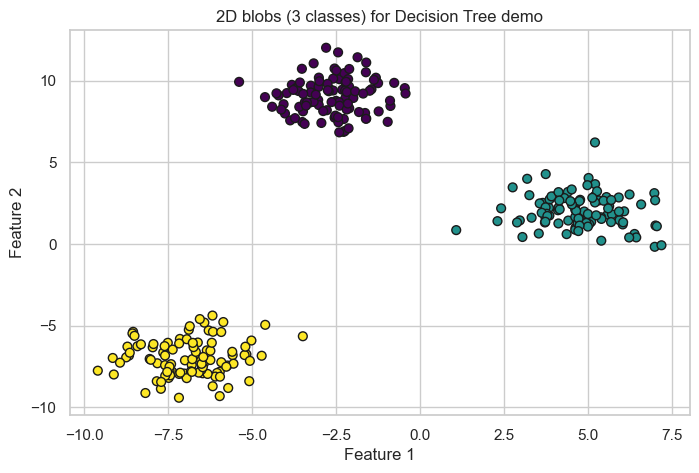

In [2]:
# Cell 8 — generate and plot blobs
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.1, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=40, edgecolor='k')
plt.title("2D blobs (3 classes) for Decision Tree demo")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# 🎨 Decision Boundary Helper (For Plotting Any Classifier)

---

We'll create a **helper function** to **visualize decision regions** for a trained model.


In [ ]:
# Cell 10 — decision boundary function
def plot_decision_regions(model, X, y, title=None, mesh_step=0.05, eps=0.6, cmap='viridis'):
    x_min, x_max = X[:,0].min() - eps, X[:,0].max() + eps
    y_min, y_max = X[:,1].min() - eps, X[:,1].max() + eps
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step),
                         np.arange(y_min, y_max, mesh_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolor='k', s=40)
    if title:
        plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# 🌳 Fit scikit-learn DecisionTreeClassifier & Plot Decision Boundary

---

We'll **train a classifier** with default parameters (CART using **Gini impurity**) and **visualize the partitioning** of the feature space.


Test accuracy: 1.0


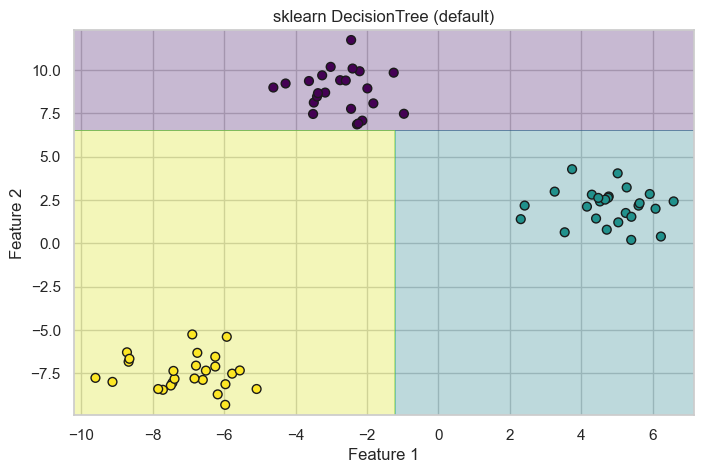

In [4]:
# Cell 12 — sklearn decision tree (default)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

# plot decision regions
plot_decision_regions(dt, X_test, y_test, title="sklearn DecisionTree (default)")


# 🏗️ Visualize the Fitted Tree Structure (Text + Plot)

---

We can **inspect the tree rules** as **text** and also **plot the tree**.  

> ⚠️ For larger trees, the plot may become crowded.


Textual rules:

|--- f2 <= 6.52
|   |--- f1 <= -1.21
|   |   |--- class: 2
|   |--- f1 >  -1.21
|   |   |--- class: 1
|--- f2 >  6.52
|   |--- class: 0



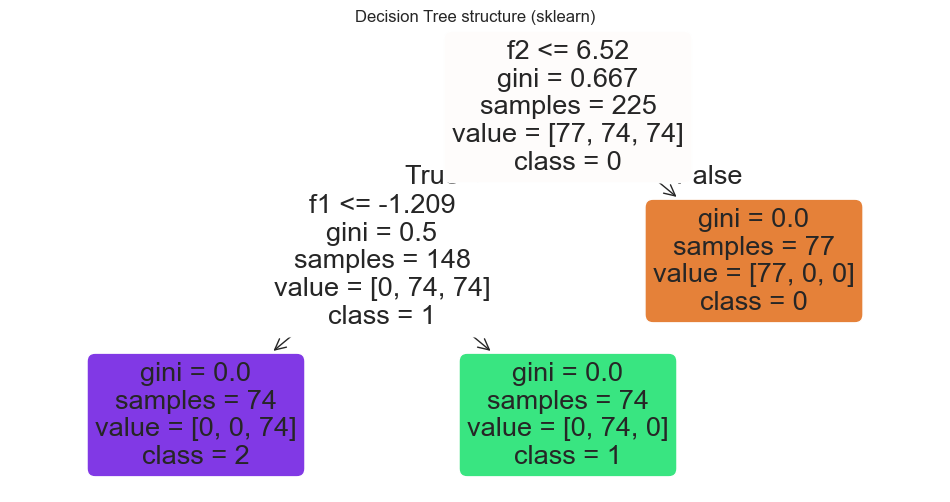

In [5]:
# Cell 14 — textual description and plot
print("Textual rules:\n")
print(export_text(dt, feature_names=['f1', 'f2']))

plt.figure(figsize=(12,6))
plot_tree(dt, feature_names=['f1', 'f2'], class_names=[str(c) for c in dt.classes_], filled=True, rounded=True)
plt.title("Decision Tree structure (sklearn)")
plt.show()


# ⚖️ Effect of `max_depth`: Underfitting vs Overfitting

---

We'll **train trees** with different `max_depth` values and **show decision boundaries** to illustrate the **bias-variance trade-off**.


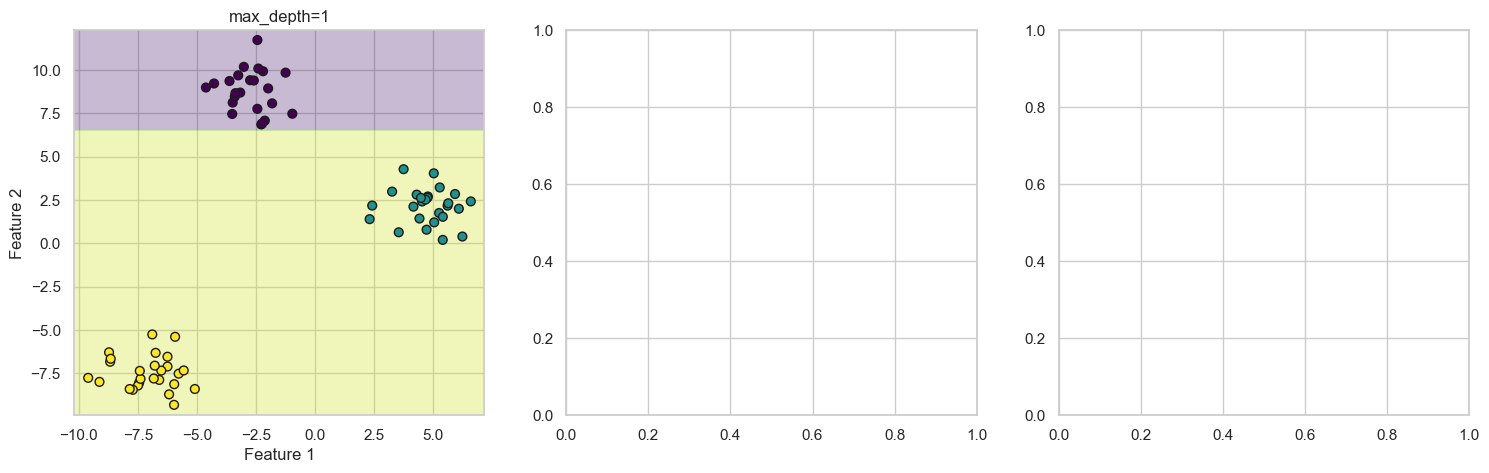

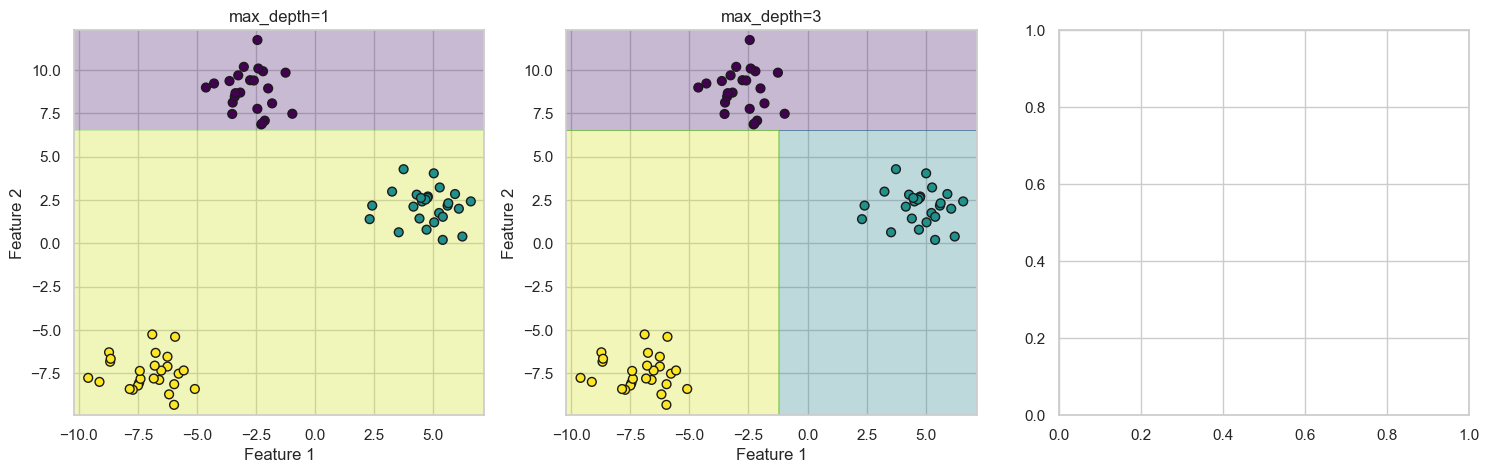

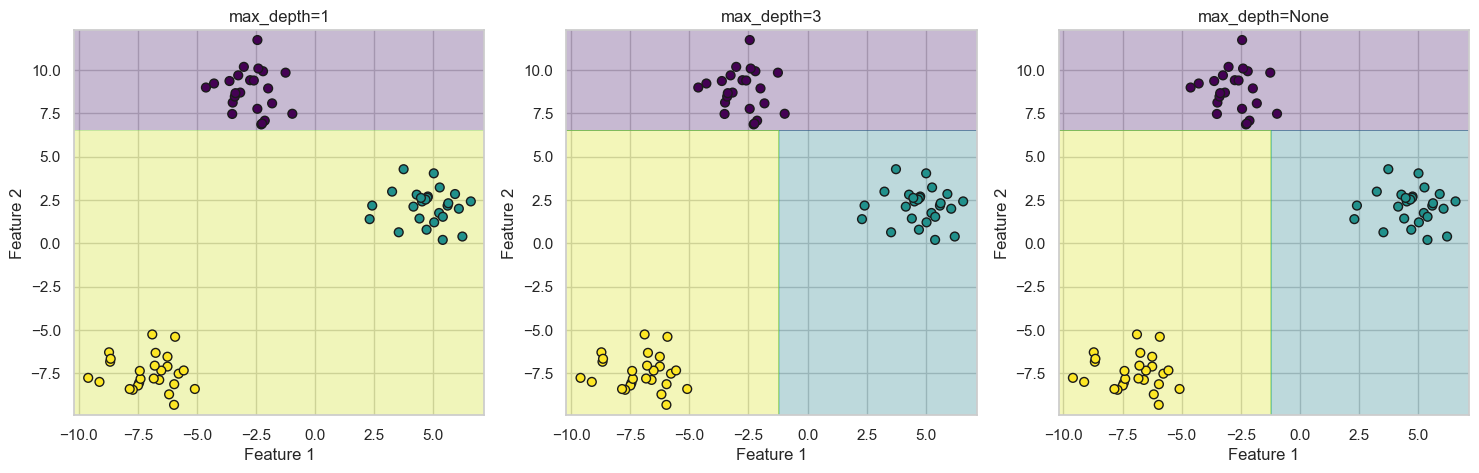

In [6]:
# Cell 16 — decision boundaries for various max_depth
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, depth in zip(axes, [1, 3, None]):
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    plt.sca(ax)
    plot_decision_regions(model, X_test, y_test, title=f"max_depth={depth}")
plt.show()


# 📊 Feature Importance

---

Trees provide **feature importances** (Gini importance).  

We'll **demonstrate** this on a **synthetic dataset** with multiple features.


Feature 0: importance = 0.0690
Feature 1: importance = 0.0387
Feature 2: importance = 0.0057
Feature 3: importance = 0.0401
Feature 4: importance = 0.2357
Feature 5: importance = 0.6108


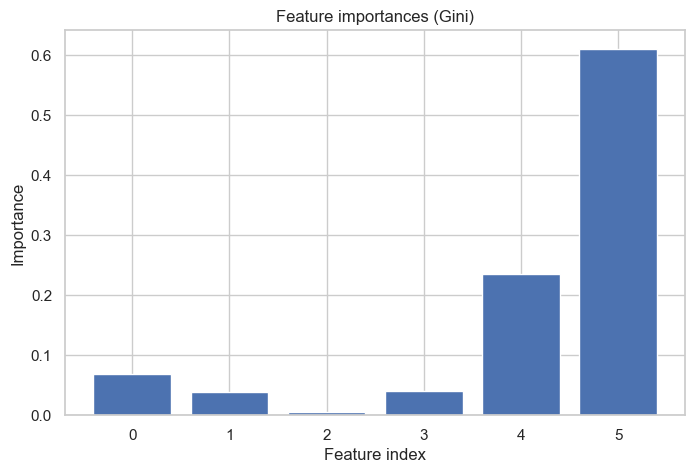

In [7]:
# Cell 18 — feature importance demo
from sklearn.datasets import make_classification
Xf, yf = make_classification(n_samples=500, n_features=6, n_informative=2, n_redundant=0, random_state=0)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.3, random_state=0)

dt2 = DecisionTreeClassifier(random_state=0)
dt2.fit(Xf_train, yf_train)
importances = dt2.feature_importances_
for i, imp in enumerate(importances):
    print(f"Feature {i}: importance = {imp:.4f}")
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Feature importances (Gini)")
plt.show()


# 🌳 Decision Tree for Regression (scikit-learn)

---

We'll create a **simple 1D regression problem** and show how trees perform **piecewise constant regression**.


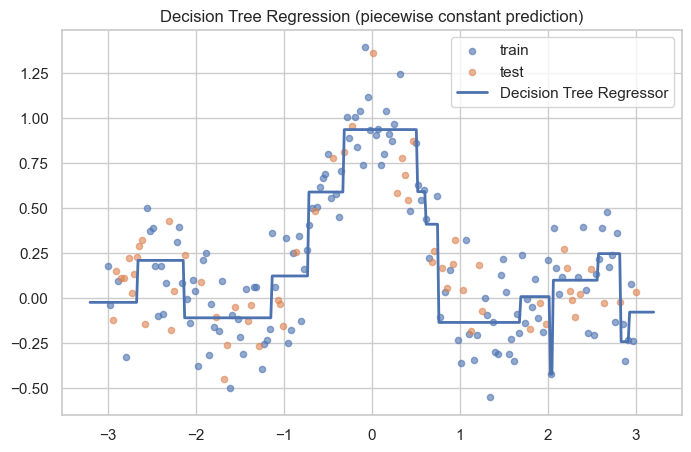

Test MSE: 0.04171851140427912


In [8]:
# Cell 20 — regression data and decision tree regressor
Xr = np.linspace(-3, 3, 200).reshape(-1,1)
yr = np.sinc(Xr[:,0]) + 0.2 * np.random.randn(len(Xr))

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=2)
dtr = DecisionTreeRegressor(max_depth=4, random_state=0)
dtr.fit(Xr_train, yr_train)
X_grid = np.linspace(Xr.min()-0.2, Xr.max()+0.2, 400).reshape(-1,1)
y_pred = dtr.predict(X_grid)

plt.scatter(Xr_train, yr_train, s=20, alpha=0.6, label='train')
plt.scatter(Xr_test, yr_test, s=20, alpha=0.6, label='test')
plt.plot(X_grid, y_pred, linewidth=2, label='Decision Tree Regressor')
plt.legend()
plt.title("Decision Tree Regression (piecewise constant prediction)")
plt.show()
print("Test MSE:", mean_squared_error(yr_test, dtr.predict(Xr_test)))


# ⚙️ Hyperparameter Tuning: Grid Search for `max_depth` and `min_samples_leaf`

---

We'll **search for the best** `max_depth` and `min_samples_leaf` using **GridSearchCV** (classification example).



In [9]:
# Cell 22 — Grid search for tree hyperparameters
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, None],
    'min_samples_leaf': [1, 2, 5, 10]
}
gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)


Best params: {'max_depth': 2, 'min_samples_leaf': 1}
Best CV score: 1.0


# ✂️ Pruning: Cost-Complexity Pruning (`ccp_alpha`) in scikit-learn

---

scikit-learn supports **cost-complexity pruning** via `ccp_alpha`.  

- Compute the **effective alphas** and the **corresponding subtree sequence** using `cost_complexity_pruning_path`.  
- Choose a **suitable alpha** via **cross-validation** to control tree complexity and reduce overfitting.


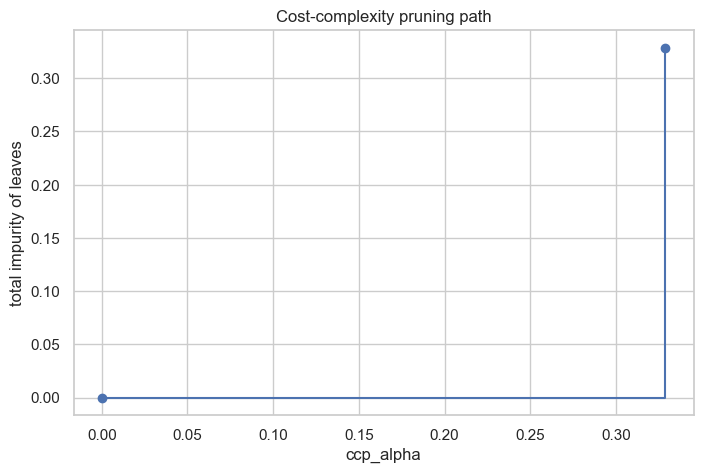

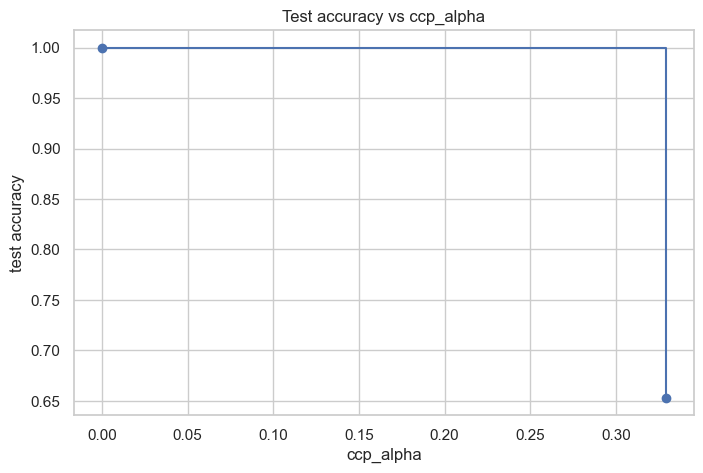

In [10]:
# Cell 24 — demonstrate cost-complexity pruning path
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # last alpha would prune all leaves
impurities = path.impurities[:-1]

plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("total impurity of leaves")
plt.title("Cost-complexity pruning path")
plt.show()

# Fit trees for each alpha and evaluate on test set
trees = []
test_scores = []
for ccp in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp)
    clf.fit(X_train, y_train)
    trees.append(clf)
    test_scores.append(clf.score(X_test, y_test))

plt.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("test accuracy")
plt.title("Test accuracy vs ccp_alpha")
plt.show()


# 🏗️ Building a Decision Tree from Scratch (Overview)

---

We'll implement a **simple CART-like decision tree** for **numeric features**:

- ✂️ **Binary splits only:** feature $j$ and threshold $t$ →  
  - Left: $x_j \le t$  
  - Right: $x_j > t$  
- 🌳 **Classification:** use **Gini impurity**  
- 📏 **Regression:** use **MSE (variance)**  
- 🔍 **Greedy selection among candidate thresholds:** consider thresholds between consecutive **sorted unique feature values**  
- ⚙️ **Stopping criteria:** `max_depth`, `min_samples_split`, `min_impurity_decrease`

> 💡 The implementation is **educational** (not optimized for extremely large datasets) but fully **functional**.


In [11]:
# Cell 26 — Decision tree from-scratch implementation (CART-style)
import math
from collections import Counter, namedtuple

# Node structure
_Node = namedtuple("_Node", ["is_leaf", "prediction", "feature_index", "threshold", "left", "right", "n_samples", "impurity"])

class SimpleDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_impurity_decrease=0.0, task='classification'):
        """
        task: 'classification' or 'regression'
        """
        self.max_depth = float('inf') if max_depth is None else max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.task = task
        self.root = None
    
    # impurity functions
    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0.0
        counts = np.bincount(y) if y.dtype.kind in 'iu' else Counter(y)
        if isinstance(counts, Counter):
            probs = np.array(list(counts.values())) / m
        else:
            probs = counts / m
            probs = probs[probs > 0]
        return 1.0 - np.sum(probs**2)
    
    def _entropy(self, y):
        m = len(y)
        if m == 0:
            return 0.0
        counts = np.bincount(y)
        probs = counts[counts>0] / m
        return -np.sum(probs * np.log2(probs))
    
    def _mse(self, y):
        if len(y) == 0:
            return 0.0
        return np.mean((y - np.mean(y))**2)
    
    def _impurity(self, y):
        if self.task == 'classification':
            return self._gini(y)
        else:
            return self._mse(y)
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_features_ = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)
        return self
    
    def _best_split(self, X, y):
        # returns (best_feature, best_threshold, best_impurity_decrease, left_idx, right_idx)
        m, n_features = X.shape
        if m < self.min_samples_split:
            return None
        
        parent_impurity = self._impurity(y)
        best = None
        # For each feature consider thresholds
        for feature in range(n_features):
            xs = X[:, feature]
            # sort by feature value
            sorted_idx = np.argsort(xs)
            xs_sorted = xs[sorted_idx]
            y_sorted = y[sorted_idx]
            # candidate thresholds are midpoints between consecutive unique values
            for i in range(self.min_samples_leaf, m - self.min_samples_leaf + 1):
                # only consider a split if value changes
                if xs_sorted[i-1] == xs_sorted[i]:
                    continue
                threshold = (xs_sorted[i-1] + xs_sorted[i]) / 2.0
                left_y = y_sorted[:i]
                right_y = y_sorted[i:]
                n_left = len(left_y); n_right = len(right_y)
                impurity_left = self._impurity(left_y)
                impurity_right = self._impurity(right_y)
                weighted_impurity = (n_left * impurity_left + n_right * impurity_right) / m
                impurity_decrease = parent_impurity - weighted_impurity
                if (best is None) or (impurity_decrease > best[2]):
                    best = (feature, threshold, impurity_decrease, sorted_idx[:i], sorted_idx[i:])
        return best
    
    def _build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        node_impurity = self._impurity(y)
        # Stopping conditions
        if (depth >= self.max_depth) or (n_samples < self.min_samples_split) or (node_impurity == 0.0):
            # make leaf
            if self.task == 'classification':
                # majority class
                vals, cnts = np.unique(y, return_counts=True)
                pred = vals[np.argmax(cnts)]
            else:
                pred = np.mean(y)
            return _Node(True, pred, None, None, None, None, n_samples, node_impurity)
        
        best = self._best_split(X, y)
        if best is None or best[2] < self.min_impurity_decrease:
            # do not split
            if self.task == 'classification':
                vals, cnts = np.unique(y, return_counts=True)
                pred = vals[np.argmax(cnts)]
            else:
                pred = np.mean(y)
            return _Node(True, pred, None, None, None, None, n_samples, node_impurity)
        # else make internal node
        feature, threshold, impurity_decrease, left_idx, right_idx = best
        left = self._build_tree(X[left_idx], y[left_idx], depth+1)
        right = self._build_tree(X[right_idx], y[right_idx], depth+1)
        return _Node(False, None, feature, threshold, left, right, n_samples, node_impurity)
    
    def predict_one(self, x):
        node = self.root
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction
    
    def predict(self, X):
        X = np.asarray(X)
        preds = np.array([self.predict_one(x) for x in X])
        return preds


# 🧩 Test Our `SimpleDecisionTree` on 2D Blobs Classification

---

We'll **fit our from-scratch model** and **compare accuracy** with scikit-learn's `DecisionTreeClassifier`.


Scratch tree accuracy: 1.0
sklearn tree accuracy: 1.0


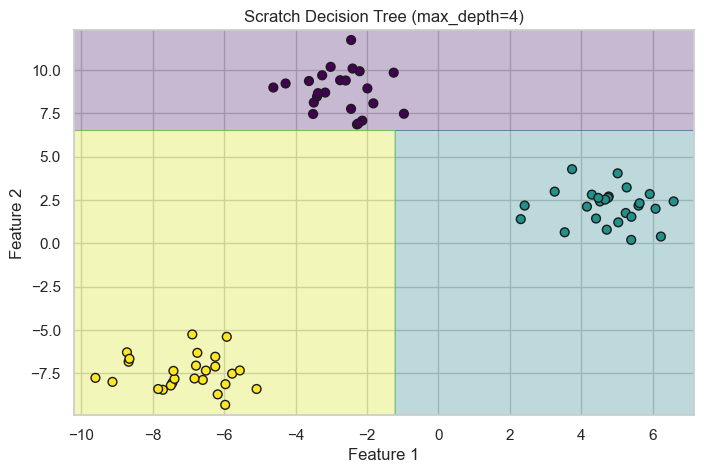

In [12]:
# Cell 28 — fit and compare
sdt = SimpleDecisionTree(max_depth=4, min_samples_split=5, min_samples_leaf=2, task='classification')
sdt.fit(X_train, y_train)
pred_sdt = sdt.predict(X_test)
print("Scratch tree accuracy:", accuracy_score(y_test, pred_sdt))

# sklearn for comparison
dt2 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=0)
dt2.fit(X_train, y_train)
print("sklearn tree accuracy:", accuracy_score(y_test, dt2.predict(X_test)))

# plot decision regions for scratch tree (wrap into predict function accepting grid)
class WrapperScratch:
    def __init__(self, tree):
        self.tree = tree
    def predict(self, X):
        return self.tree.predict(X)

plot_decision_regions(WrapperScratch(sdt), X_test, y_test, title="Scratch Decision Tree (max_depth=4)")


# 📝 How Our From-Scratch Tree Works (Brief)

---

### 🔹 Explanation Summary

- `_best_split` enumerates **candidate splits** by sorting each feature and trying **midpoints** between consecutive values.  
- For each candidate split, compute **impurity decrease**:  
  - **Gini** for classification  
  - **MSE (variance)** for regression  
- Choose the split with **maximal impurity decrease** that respects `min_samples_leaf`.  
- Recursively build **left** and **right subtrees** until **stopping criteria** are met.  
- **Prediction:** walk the tree, comparing `feature <= threshold` at each node until a **leaf** is reached.

> 💡 This is a **greedy top-down CART-style algorithm**; simple and illustrative, but not highly optimized.


# 🌳 Demonstrate Regression with the Scratch Tree

---

We'll use the **same 1D regression data** as earlier and fit our **from-scratch regressor** (minimizing **MSE**).


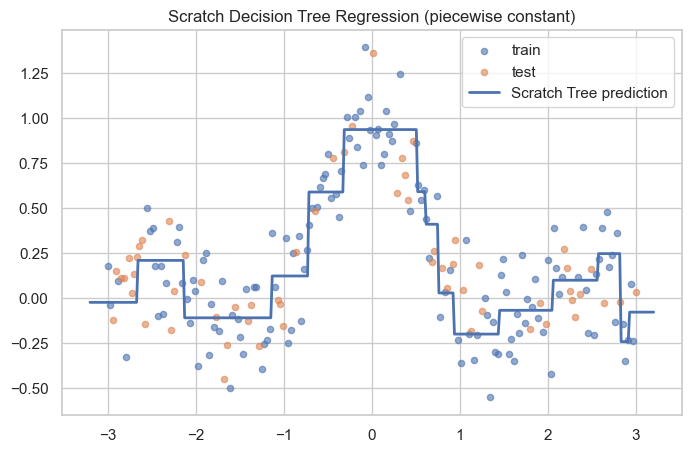

Scratch tree test MSE: 0.04147856751940146
sklearn DecisionTreeRegressor test MSE: 0.04171851140427912


In [13]:
# Cell 31 — test scratch tree on regression
sdt_reg = SimpleDecisionTree(max_depth=4, min_samples_split=5, min_samples_leaf=2, task='regression')
sdt_reg.fit(Xr_train, yr_train)
y_pred_sdt = sdt_reg.predict(X_grid)  # predictions on grid
plt.scatter(Xr_train, yr_train, s=20, alpha=0.6, label='train')
plt.scatter(Xr_test, yr_test, s=20, alpha=0.6, label='test')
plt.plot(X_grid, y_pred_sdt, label='Scratch Tree prediction', linewidth=2)
plt.legend()
plt.title("Scratch Decision Tree Regression (piecewise constant)")
plt.show()

print("Scratch tree test MSE:", mean_squared_error(yr_test, sdt_reg.predict(Xr_test)))
print("sklearn DecisionTreeRegressor test MSE:", mean_squared_error(yr_test, dtr.predict(Xr_test)))


# ⚡ Complexity & Practical Tips

---

## 🔹 Complexity

- **Training:**  
  - Naive: $O(n_{\text{features}} \cdot n_{\text{samples}} \cdot \log n_{\text{samples}})$ for considering thresholds (dominant factor), repeated for each split.  
  - Worst-case: $O(n_{\text{samples}}^2 \cdot n_{\text{features}})$ for degenerate splits.  

- **Prediction:** $O(\text{depth})$ per sample.

---

## 🔹 Practical Tips

- Limit `max_depth` or set `min_samples_leaf` to avoid overfitting.  
- Use `ccp_alpha` (**cost-complexity pruning**) in scikit-learn to prune automatically.  
- Trees **do not require feature scaling**.  
- For categorical variables, encode thoughtfully:  
  - One-hot may cause many branches; consider specialized splits.  
- For better performance, consider **ensemble methods** (Random Forests, Gradient Boosting).


# ⚖️ Pros & Cons Summary

---

## 🔹 Pros

- ✅ **Interpretable decision rules** (good for explanation)  
- 🌐 **Handles heterogeneous data types** with proper preprocessing  
- ⚡ **Fast inference** once trained

---

## 🔹 Cons

- ⚠️ **High variance** and tendency to overfit  
- 📐 **Axis-aligned splits** may be inefficient for rotated decision boundaries  
- 🔍 **Greedy building** is not guaranteed to be globally optimal

---

## 🔹 When to Prefer Trees

- When **interpretability** and **rule extraction** are important  
- As **base learners in ensemble methods** (trees are the building block of Random Forests and Boosted Trees)


# 🚀 Next Steps & Experiments You Can Try

---

1. 🌟 Try **Decision Trees** on real datasets: Iris, Breast Cancer, or tabular datasets from UCI/Kaggle.  
2. 🔄 Compare **single tree** vs **Random Forest / Gradient Boosted Trees**.  
3. ⚙️ Explore `max_features` in RandomForest and observe its effect on **tree diversity**.  
4. 🧮 Try different **impurity measures**: `criterion='entropy'` vs `'gini'`.  
5. 📜 Use `export_text` to extract **human-readable rules** and interpret them.  
6. 🔍 Measure **stability**: retrain trees on bootstrapped samples and compare tree structures.

---

> 🎯 **End of Decision Tree Notebook** — you now have **theory, scikit-learn usage, visualizations, and a working from-scratch implementation** to experiment with.
